In [66]:
from os import write

import pandas as pd
import numpy as np
import sqlite3
import csv
import matplotlib.pyplot as plt

    # Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [67]:
# write your code here
db_path = "../db.sqlite3"
csv_file_path = "combined_data.csv"
query_all = """
    SELECT
    o.id AS order_id,
    o.datetime AS order_datetime,
    p.id AS product_id,
    p.name AS product_name,
    p.price AS product_price,
    oi.quantity AS quantity,
    (p.price * oi.quantity) AS total_price
FROM
    restaurant_orderitem oi
JOIN
    restaurant_order o ON oi.order_id = o.id
JOIN
    restaurant_product p ON oi.product_id = p.id
ORDER BY
    o.datetime, o.id;
"""

with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()
    cursor.execute(query_all)
    rows = cursor.fetchall()
    column_names = [description[0] for description in cursor.description]
    with open(csv_file_path, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(column_names)
        writer.writerows(rows)

In [68]:
restaurant_df = pd.read_csv("combined_data.csv")
restaurant_df.head()

,order_id,order_datetime,product_id,product_name,product_price,quantity,total_price
0,12392,2015-09-01 14:42:00,52,Onion Bhaji,3.95,1,3.95
1,12391,2015-09-08 17:12:00,52,Onion Bhaji,3.95,1,3.95
2,12390,2015-09-08 17:31:00,52,Onion Bhaji,3.95,1,3.95
3,12389,2015-09-08 17:56:00,52,Onion Bhaji,3.95,1,3.95
4,12388,2015-09-09 09:31:00,52,Onion Bhaji,3.95,1,3.95


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

In [69]:
# write your code here
products_quantity = (
    restaurant_df.groupby(["product_name", "product_price"])["quantity"].sum().reset_index())

top_10_products = products_quantity.sort_values(by="quantity", ascending=False)[:10]
all_quantity = top_10_products["quantity"].sum()
top_10_products["percentage"] \
    = ((top_10_products["quantity"] / all_quantity) * 100).round(1).astype(str) + " %"
top_10_products

,product_name,product_price,quantity,percentage
188,Plain Papadum,0.80,10648,26.8 %
186,Pilau Rice,2.95,6367,16.0 %
187,Plain Naan,2.60,4983,12.5 %
81,Garlic Naan,2.95,3318,8.3 %
189,Plain Rice,2.95,2964,7.5 %
165,Onion Bhajee,3.95,2749,6.9 %
144,Mango Chutney,0.50,2504,6.3 %
52,Chicken Tikka Masala,8.95,2473,6.2 %
26,Chapati,1.95,1935,4.9 %
153,Mint Sauce,0.50,1840,4.6 %


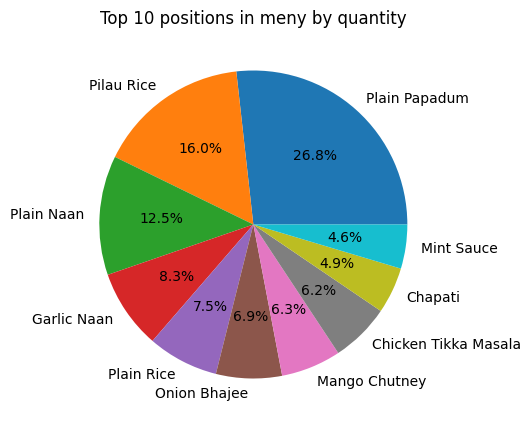

In [77]:
plt.figure(figsize=(8, 5))
plt.pie(
    top_10_products["quantity"],  # Values for the pie chart
    labels=top_10_products["product_name"],  # Labels for each slice
    autopct="%1.1f%%",  # Display percentages with 1 decimal place
)
plt.title("Top 10 positions in meny by quantity")
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

In [71]:
# write your code here
products_quantity["item_price"] = products_quantity["product_price"] * products_quantity["quantity"]
top_10_prices = products_quantity.sort_values(by="item_price", ascending=False).head(10)

total_item_prices = top_10_prices["item_price"].sum()

top_10_prices["prices_percentage"] = (top_10_prices["item_price"] / total_item_prices) * 100
top_10_prices

,product_name,product_price,quantity,item_price,prices_percentage
52,Chicken Tikka Masala,8.95,2473,22133.35,17.454050
186,Pilau Rice,2.95,6367,18782.65,14.811735
187,Plain Naan,2.60,4983,12955.80,10.216763
97,Korma,8.95,1370,12261.50,9.669247
16,Bombay Aloo,5.95,1831,10894.45,8.591211
165,Onion Bhajee,3.95,2749,10858.55,8.562901
20,Butter Chicken,9.95,1068,10626.60,8.379988
81,Garlic Naan,2.95,3318,9788.10,7.718759
98,Korma - Chicken,8.95,1091,9764.45,7.700109
189,Plain Rice,2.95,2964,8743.80,6.895238


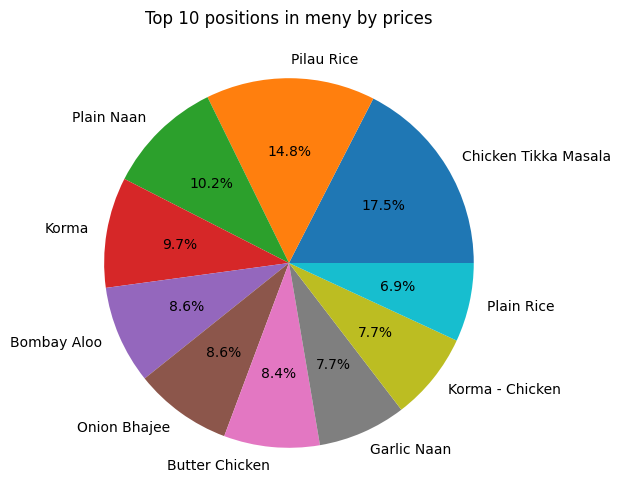

In [72]:
plt.figure(figsize=(10, 6))
plt.pie(
    top_10_prices["item_price"],
    labels=top_10_prices["product_name"],
    autopct="%1.1f%%",
)
plt.title("Top 10 positions in meny by prices")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific hour the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

In [73]:
# write your code here
restaurant_df["order_datetime"] = pd.to_datetime(restaurant_df["order_datetime"])
restaurant_df["order_hour"] = restaurant_df["order_datetime"].dt.hour
restaurant_df

,order_id,order_datetime,product_id,product_name,product_price,quantity,total_price,order_hour
0,12392,2015-09-01 14:42:00,52,Onion Bhaji,3.95,1,3.95,14
1,12391,2015-09-08 17:12:00,52,Onion Bhaji,3.95,1,3.95,17
2,12390,2015-09-08 17:31:00,52,Onion Bhaji,3.95,1,3.95,17
3,12389,2015-09-08 17:56:00,52,Onion Bhaji,3.95,1,3.95,17
4,12388,2015-09-09 09:31:00,52,Onion Bhaji,3.95,1,3.95,9
...,...,...,...,...,...,...,...,...
74813,1,2019-08-03 20:25:00,240,King Prawn Balti,12.95,1,12.95,20
74814,1,2019-08-03 20:25:00,19,Garlic Naan,2.95,1,2.95,20
74815,1,2019-08-03 20:25:00,36,Mushroom Rice,3.95,1,3.95,20
74816,1,2019-08-03 20:25:00,111,Paneer Tikka Masala,8.95,1,8.95,20


In [74]:
hours_statistic_df = restaurant_df.groupby("order_hour")["total_price"].sum()
hours_statistic_df

order_hour
0        177.95
1         54.65
2        199.25
3          8.90
4         63.45
5         57.40
6        121.60
8        447.70
9        570.60
10      1250.35
11      3807.05
12     10565.85
13      8282.65
14      3343.55
15      3781.70
16     15634.75
17     72110.20
18    132462.50
19    109045.05
20     50218.25
21     21480.30
22     11001.50
23       373.25
Name: total_price, dtype: float64

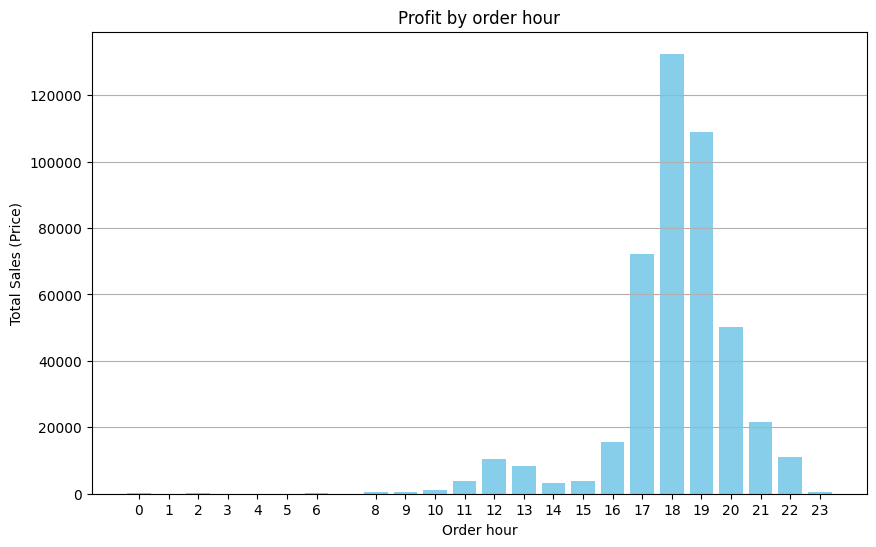

In [75]:
plt.figure(figsize=(10, 6))
plt.bar(hours_statistic_df.index, hours_statistic_df.values, color="skyblue")
plt.title("Profit by order hour")
plt.xlabel("Order hour")
plt.ylabel("Total Sales (Price)")
plt.xticks(hours_statistic_df.index)  # Set x-ticks to the hour values
plt.grid(axis="y")
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

In [81]:
# write your code here
restaurant_df["order_day_of_the_week"] = restaurant_df["order_datetime"].dt.day_name()
restaurant_df

,order_id,order_datetime,product_id,product_name,product_price,quantity,total_price,order_hour,order_day_of_the_week
0,12392,2015-09-01 14:42:00,52,Onion Bhaji,3.95,1,3.95,14,Tuesday
1,12391,2015-09-08 17:12:00,52,Onion Bhaji,3.95,1,3.95,17,Tuesday
2,12390,2015-09-08 17:31:00,52,Onion Bhaji,3.95,1,3.95,17,Tuesday
3,12389,2015-09-08 17:56:00,52,Onion Bhaji,3.95,1,3.95,17,Tuesday
4,12388,2015-09-09 09:31:00,52,Onion Bhaji,3.95,1,3.95,9,Wednesday
...,...,...,...,...,...,...,...,...,...
74813,1,2019-08-03 20:25:00,240,King Prawn Balti,12.95,1,12.95,20,Saturday
74814,1,2019-08-03 20:25:00,19,Garlic Naan,2.95,1,2.95,20,Saturday
74815,1,2019-08-03 20:25:00,36,Mushroom Rice,3.95,1,3.95,20,Saturday
74816,1,2019-08-03 20:25:00,111,Paneer Tikka Masala,8.95,1,8.95,20,Saturday


In [82]:
total_rest_income_by_week_day_df = restaurant_df.groupby("order_day_of_the_week")["total_price"].sum()
total_rest_income_by_week_day_df

order_day_of_the_week
Friday       100339.15
Monday        40008.30
Saturday     112191.65
Sunday        67105.95
Thursday      46021.55
Tuesday       38145.65
Wednesday     41246.20
Name: total_price, dtype: float64

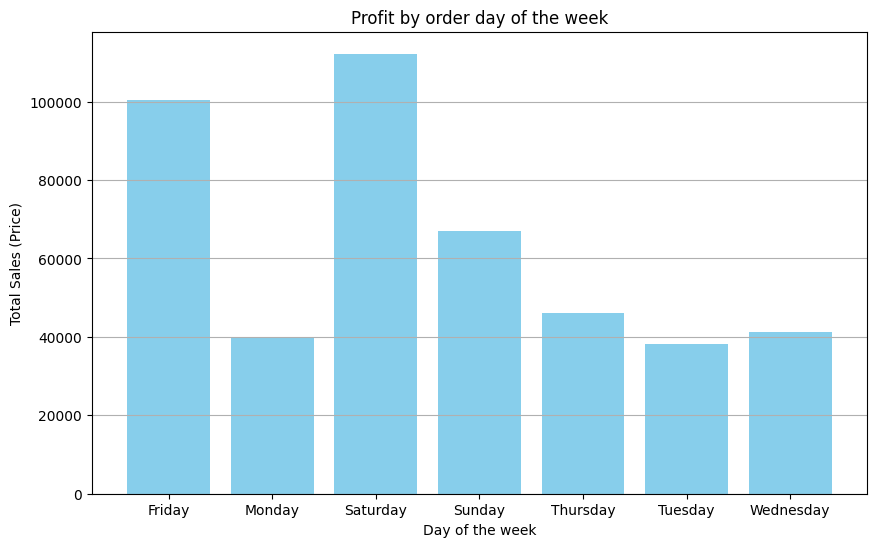

In [85]:
plt.figure(figsize=(10, 6))
plt.bar(total_rest_income_by_week_day_df.index, total_rest_income_by_week_day_df.values, color="skyblue")
plt.title("Profit by order day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Total Sales (Price)")
plt.xticks(total_rest_income_by_week_day_df.index)  # Set x-ticks to the hour values
plt.grid(axis="y")
plt.show()
